# EDA1
**대회 개요**

    - 5개의 인간 장기에 걸쳐 기능 조직 단위(FTU)를 식별,분할.
    - FTU를 가능한 한 정확하게 분할하여 제출
    - 조직 섹션 이미지의 데이터 세트를 사용하여 모델을 구축
    
**EDA1**

    - masked image 생성

## 라이브러리 호출

In [181]:
import os
import glob
import cv2

import numpy as np
import pandas as pd
import tifffile as tiff 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tqdm.auto import tqdm
plt.style.use("Solarize_Light2")

In [25]:
from Myfunc import resumetable # dataframe info

## 경로 지정

In [150]:
BASE_PATH = "D:Dataset/dataset/hubmap-organ-segmentation"

## 데이터 설명
* 총 데이터의 개수 351개
- HPA : Human Protein Atlas (인간 단백질 지도)
- HuBMAP : Human BioMolecular Atlas Program (인간 세포지도 작성 프로그램)
    - HPA의 세포단계
    
---
* id : 이미지의 ID
* organ : 장기 종류
* data_source :  HuBMAP or HPA.
* img_height : 이미지 높이
* img_width : 이미지 너비
* pixel_size : 이미지 높이와 너비의 한 픽셀이 가지는 실제 크기 - 단위(µm) 
    - Data_Source가 HPA 에서 모든 pixel_size 는 0.4 ( df의 모든 데이터는 HPA 이다 )
    - Data_Source가 HuBMAP 에서는
        - kidney : 0.5
        - large intestine : 0.2290
        - lung : 0.7562
        - spleen : 0.4945
        - prostate : 6.263
        
* tissue_thickness : 샘플의 두께 - 단위(µm)
    - Data_Source가 HPA 에서 모든 thickness 는 4
    - Data_Source가 HuBMAP 에서는
        - kidney : 10
        - large intestine : 8
        - lung : 5
        - spleen : 4
        - prostate : 5
* rle : 타겟 (training set only)
* age : 환자의 나이 (training set only)
* sex : 환자의 성별 (training set only)

## 데이터 로드

In [151]:
df = pd.read_csv( os.path.join(BASE_PATH, "train.csv"))
df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [152]:
df.tail()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male
350,9904,largeintestine,HPA,3000,3000,0.4,4,1009165 7 1012149 28 1015140 38 1018127 51 102...,84.0,Male


In [153]:
resumetable(df)

데이터 셋 형상 : (351, 10)


,피처,데이터 타입,결측값 개수,고윳값 개수,1번째,2번째,3번째,4번째,5번째
0,id,int64,0,351,"[10044, 1]","[10274, 1]","[10392, 1]","[10488, 1]","[10610, 1]"
1,organ,object,0,5,"[prostate, 93]","[spleen, 53]","[lung, 48]","[kidney, 99]","[largeintestine, 58]"
2,data_source,object,0,1,"[HPA, 351]","[NaN, NaN]","[NaN, NaN]","[NaN, NaN]","[NaN, NaN]"
3,img_height,int64,0,20,"[3000, 326]","[2867, 1]","[2654, 2]","[2727, 1]","[2680, 1]"
4,img_width,int64,0,20,"[3000, 326]","[2867, 1]","[2654, 2]","[2727, 1]","[2680, 1]"
5,pixel_size,float64,0,1,"[0.4, 351]","[NaN, NaN]","[NaN, NaN]","[NaN, NaN]","[NaN, NaN]"
6,tissue_thickness,int64,0,1,"[4, 351]","[NaN, NaN]","[NaN, NaN]","[NaN, NaN]","[NaN, NaN]"
7,rle,object,0,351,[1459676 77 1462675 82 1465674 87 1468673 92 1...,[715707 2 718705 8 721703 11 724701 18 727692 ...,[1228631 20 1231629 24 1234624 40 1237623 47 1...,[3446519 15 3449517 17 3452514 20 3455510 24 3...,[478925 68 481909 87 484893 105 487863 154 490...
8,age,float64,0,28,"[37.0, 10]","[76.0, 13]","[82.0, 7]","[78.0, 6]","[21.0, 13]"
9,sex,object,0,2,"[Male, 229]","[Female, 122]","[NaN, NaN]","[NaN, NaN]","[NaN, NaN]"


## Single Sample

### img sample

In [195]:
img_id_1 = 10044
img_1 = tiff.imread(os.path.join(BASE_PATH,"train_images",str(img_id_1)+".tiff"))
print(img_1.shape)

(3000, 3000, 3)


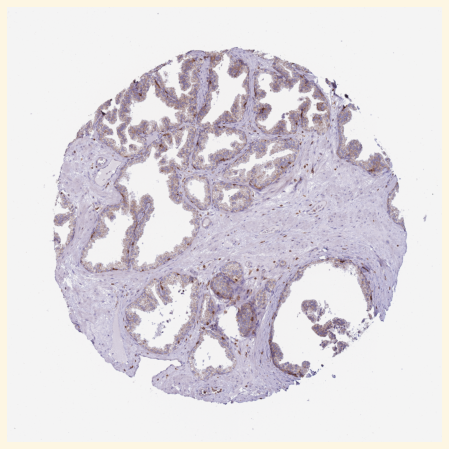

In [197]:
plt.figure(figsize=(8, 8))
plt.imshow(img_1)
plt.axis("off");

### rle2mask

In [156]:
# rle
rle = df[df["id"]==img_id_1]["rle"].iloc[-1][:102]
s = temp.split() # space 를 기준으로 split
print("rle :",rle)
print("s :", s)
print("start_point :", s[0:][::2])
print("length :",s[1:][::2])

rle : 1459676 77 1462675 82 1465674 87 1468673 92 1471671 97 1474669 101 1477667 105 1480665 109 1483664 115
s : ['1459676', '77', '1462675', '82', '1465674', '87', '1468673', '92', '1471671', '97', '1474669', '101', '1477667', '105', '1480665', '109', '1483664', '115']
start_point : ['1459676', '1462675', '1465674', '1468673', '1471671', '1474669', '1477667', '1480665', '1483664']
length : ['77', '82', '87', '92', '97', '101', '105', '109', '115']


In [157]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])] # 
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [158]:
mask_1 = rle2mask(df[df["id"]==img_id_1]["rle"].iloc[-1], (img_1.shape[1], img_1.shape[0]))
mask_1.shape

(3000, 3000)

### target masked image

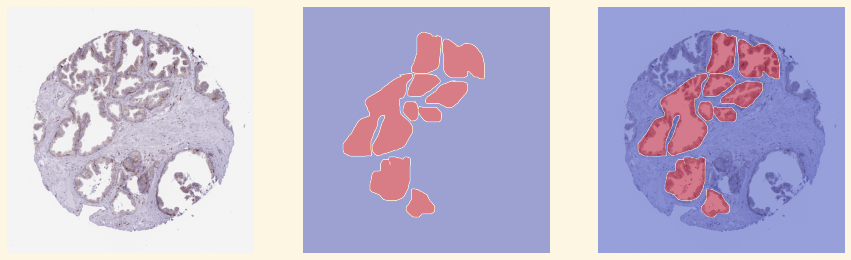

In [159]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.imshow(img_1)
plt.axis("off")
plt.subplot(132)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")
plt.subplot(133)
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off");

## masked image 저장

In [160]:
image_ids = df.id
image_files = glob.glob(os.path.join(BASE_PATH,"train_images/*"))

In [161]:
def save_table(table_name):
    for id, img in tqdm(zip(image_ids, image_files), total = len(image_ids)):
        img = tiff.imread(img)
        mask = rle2mask(df[df["id"]==id]["rle"].iloc[-1], (img.shape[1], img.shape[0]))
        plt.figure(figsize=(15,15))
        plt.axis("off")
        plt.imshow(img)
        plt.imshow(mask, cmap='coolwarm', alpha=0.5)
        
        plt.savefig(f"D:Dataset/dataset/hubmap-organ-segmentation/masked_images/{id}_image.jpg")
        plt.close()

In [162]:
save_table("Images and Masks Record")

  0%|          | 0/351 [00:00<?, ?it/s]

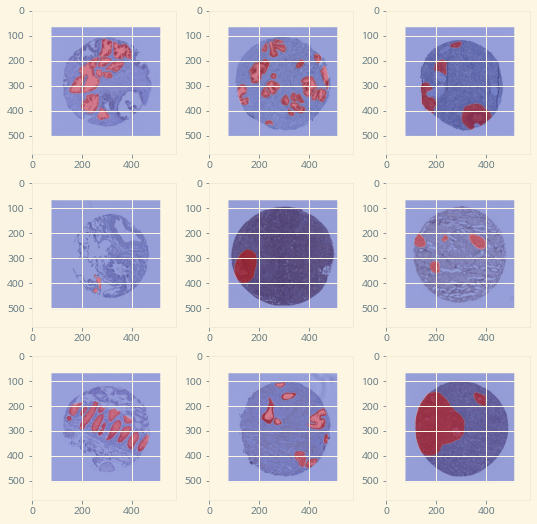

In [194]:
masked_image = glob.glob(os.path.join(BASE_PATH,"masked_images/*"))[:9]

plt.figure(figsize=(9,9))
grid = gridspec.GridSpec(3,3)
for idx, img_path in enumerate(masked_image):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax= plt.subplot(grid[idx])
    ax.imshow(img)
#     ax.axis("off")